# Setup

## Imports

In [1]:
import IPython.display as display
import os.path
import itertools
import librosa

from glob import glob
from tqdm import tqdm_notebook as tqdm
from time import time
from threading import Thread

PyTorch Modules

In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

vai Modules

In [3]:
from vai_.utils.utils import randpick, summarize_tensor
from vai_.io import pickle_load, pickle_dump

Local Modules

In [4]:
from wavenet_utils import *

## Checks

In [5]:
assert 'LJSpeech' in DIR_DATA.keys(), 'Dataset not downloaded. Please run Preprocess notebook first.'

## Hyperparameters

In [6]:
batch_size = 1
num_layers = 9
num_stacks = 2
loss_size = 1000

In [7]:
receptive_field = num_stacks * (2 ** num_layers - 1) + 2
frame_size = receptive_field + loss_size - 1
skip_size = loss_size

In [8]:
dilation_channels = 16
residual_channels = 32
skip_channels = 512
end_channels = 256

In [9]:
bias = False

Fixed

In [10]:
use_gpu = True
num_classes = 256
soft = True
shuffle = True
target_secs = 40
val_split = 0.2
silence_threshold = 0.2
sampling_rate = 16000

## Define Useful Features

In [11]:
cuda = lambda x: x.cuda() if torch.cuda.is_available() and use_gpu else x

In [12]:
DIR_DATA = DIR_DATA['LJSpeech']

In [13]:
def categorize(x):
    bins = np.linspace(-1, 1, num_classes, dtype=x.dtype)
    
    x = mu_law(x)
    if soft:
        return gaussian_filter(x, bins, std=2. / num_classes)
    else:
        x = np.minimum(np.digitize(x, bins), num_classes - 1)
        return one_hot(x, num_classes)

In [14]:
def decategorize(x, temperature=1, probabilistic=False):
    bins = np.linspace(-1, 1, num_classes, dtype=x.dtype)
    
    if soft and not probabilistic:
        epsilon = 1e-12
        return inv_mu_law(softmax(np.log(x + epsilon) / temperature).dot(bins))
    else:
        if probabilistic:
            idx = np.array([np.random.choice(np.arange(num_classes), p=p) for p in x])
        else:
            idx = x.argmax(-1)

        return inv_mu_law(bins[idx])

In [15]:
def trim_silence(audio):
    '''Removes silence at the beginning and end of a sample.'''
    energy = librosa.feature.rmse(audio)
    frames = np.nonzero(energy > silence_threshold)
    indices = librosa.core.frames_to_samples(frames)[1]

    # Note: indices can be an empty array, if the whole audio was silence.
    return audio[indices[0]:indices[-1]] if indices.size else audio[0:0]

In [16]:
hear = lambda x: display.Audio(x, rate=sampling_rate)

## Load Data

In [17]:
filenames = sorted(glob(os.path.join(DIR_DATA, 'wavs', '*.wav')))

Play sample audio

In [18]:
sample_audio = librosa.load(randpick(filenames), sampling_rate)[0]
sample_audio = sample_audio[:len(sample_audio)//frame_size*frame_size]

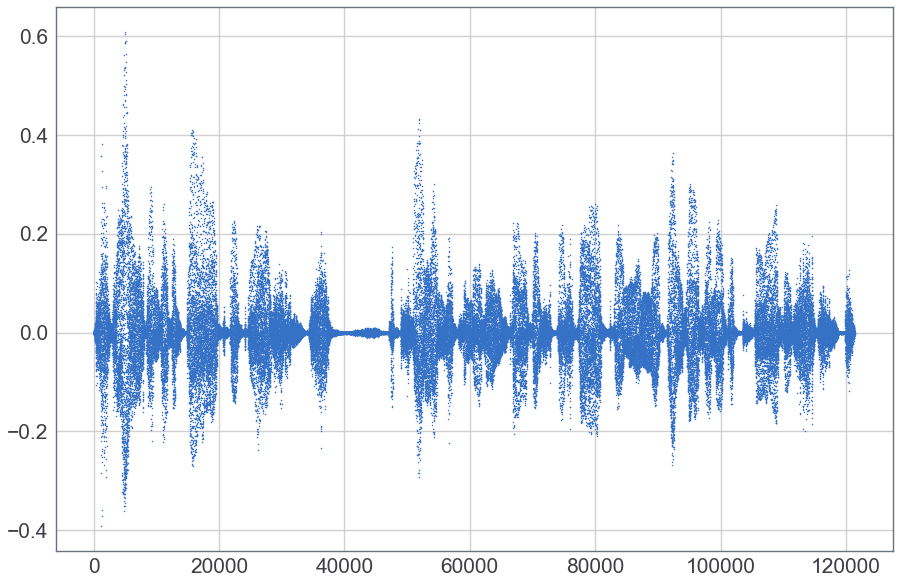

In [19]:
plot(sample_audio, '.', markersize=3)
hear(sample_audio)

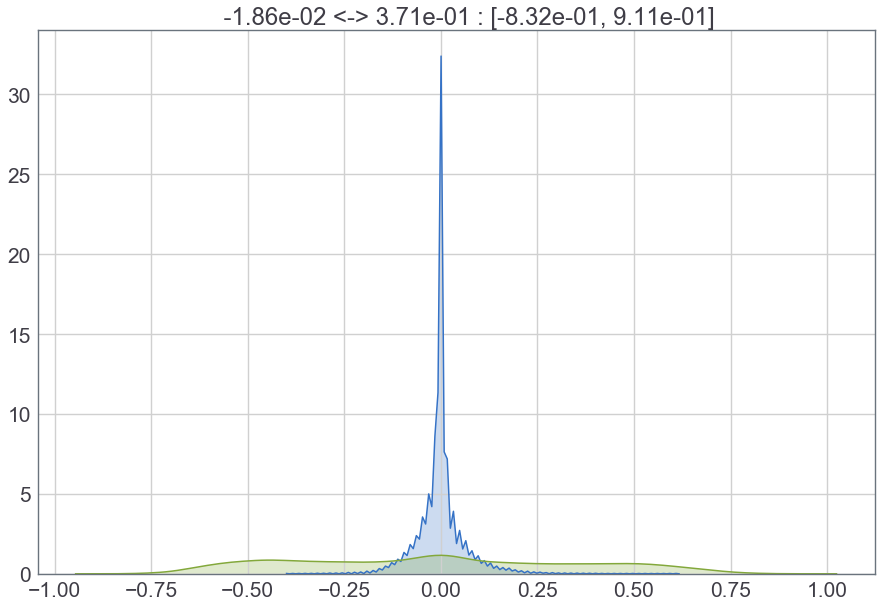

In [20]:
summarize_tensor(sample_audio, kde=True)
summarize_tensor(mu_law(sample_audio), color='g', kde=True)

In [21]:
def __make_data(filenames, data, samples, worker_idx):
    d = []
    total_samples = remaining_samples = int(np.ceil(target_secs * sampling_rate))

    for filename in filenames:
        aud = librosa.load(filename, sampling_rate)[0]
        aud = trim_silence(aud)
        samples_considered = (len(aud) - frame_size - 1) // skip_size * skip_size + frame_size + 1
        aud = aud[:samples_considered]

        if len(aud) > remaining_samples: aud = aud[:len(aud) - remaining_samples]

        start_idx = np.arange(0, len(aud) - frame_size - 1, skip_size)
        if len(start_idx) == 0: continue
        d.append(np.stack([aud[idx:idx + frame_size + 1] for idx in start_idx]))

        remaining_samples -= len(aud)
        if remaining_samples <= 0: break

    samples[worker_idx] = total_samples - remaining_samples
    data[worker_idx] = np.vstack(d)

In [22]:
def make_data(num_workers=1):
        start_idx = np.arange(0, len(filenames), len(filenames) // num_workers)
        data = [0] * num_workers
        total_samples = [0] * num_workers
        workers = [Thread(target=__make_data, args=(filenames[start_idx[i]:start_idx[i + 1]], data, total_samples, i)) for i in range(num_workers - 1)]
        workers.append(Thread(target=__make_data, args=(filenames[start_idx[-1]:], data, total_samples, num_workers - 1)))
        
        for worker in workers: worker.start()
        for worker in tqdm(workers): worker.join()
            
        idx_catch = np.where(np.cumsum(total_samples) > sampling_rate * target_secs)[0] + 1
        
        error_msg = 'Sorry! Could not find enough samples. Found {:.2f} seconds.\nTry decreasing silence_threshold or the target_secs. Or use a different dataset with higher volume.'.format(sum(total_samples) / sampling_rate)
        if len(idx_catch) == 0:
            print(error_msg)
            idx_catch = [num_workers]

        return np.vstack(data[:idx_catch[0]])

In [23]:
if os.path.exists(os.path.join(DIR_CHECKPOINTS, 'data.npz')):
    data = np.load(os.path.join(DIR_CHECKPOINTS, 'data.npz'))['data']
else:
    data = make_data(5)
    np.savez_compressed(os.path.join(DIR_CHECKPOINTS, 'data'), data=data)

In [24]:
val_idx = int(len(data) * (1 - val_split))
data_val = data[val_idx:]
data = data[:val_idx]
del val_idx

In [25]:
batches_per_epoch = int(np.ceil(len(data) / batch_size))

## Create Data Generator

Helper function which gives the inputs and targets in convinient Numpy arrays.
```start_idx``` is the indices which are used as starting indices for sampling

In [26]:
def __get_data(frame_idx, data):
    assert np.all(frame_idx < len(data)), 'a frame_idx value is unattainable'
    
    _input = categorize(data[frame_idx, :-1])
    _input = np.swapaxes(_input, 1, 2)
    
    target = categorize(data[frame_idx, -loss_size:].reshape(-1))
    
    return _input, target

Parameter ```epoch``` is a float which signifies the state of the generator.

For example, if ```epoch = 0.5```, the data is read starting from roughly the middle.

If none, data is randomly sequenced.

In [27]:
def data_generator(data, epoch=0, hop_size=batch_size):
    batch_idx = np.arange(0, len(data))
    if hop_size is None:
        while True:
            _input, target = __get_data(batch_idx, data)
            _input = Variable(cuda(torch.from_numpy(_input)), requires_grad=False)
            target = Variable(cuda(torch.from_numpy(target)), requires_grad=False)
            yield _input, target
    
    if shuffle: batch_idx = np.random.permutation(batch_idx)
        
    progress = int(np.modf(epoch)[0] * len(data))
    if progress + hop_size > len(data): progress = 0    
    
    while True:
        _input, target = __get_data(batch_idx[progress:progress + hop_size], data)
        _input = Variable(cuda(torch.from_numpy(_input)), requires_grad=False)
        target = Variable(cuda(torch.from_numpy(target)), requires_grad=False)
        
        progress += hop_size
        if progress + hop_size > len(data): progress = 0

        yield _input, target

# Define Model

A Residual Block which is repeated many times over as a stack

In [28]:
class ResBlock(nn.Module):
    def __init__(self, dilation=1, res_connect=True):
        super().__init__()
        self.conv_tanh = CausalConv1d(residual_channels, dilation_channels, 2, dilation, bias=bias)
        self.conv_sigmoid = CausalConv1d(residual_channels, dilation_channels, 2, dilation, bias=bias)
        self.conv_skip = CausalConv1d(dilation_channels, skip_channels, 1, bias=bias)
        
        self.res_connect = res_connect
        if res_connect: self.conv_res = CausalConv1d(dilation_channels, residual_channels, 1, bias=bias)
        
    def forward(self, x):
        x_tanh = F.tanh(self.conv_tanh(x))
        x_sigmoid = F.sigmoid(self.conv_sigmoid(x))
        out = x_tanh * x_sigmoid
        skip = self.conv_skip(out)
        res = self.conv_res(out) + x if self.res_connect else skip
        return res, skip

In [29]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CausalConv1d(num_classes, residual_channels, 2, bias=bias)
        self.conv2 = CausalConv1d(skip_channels, end_channels, 1, bias=bias)
        self.conv3 = CausalConv1d(end_channels, num_classes, 1, bias=bias)
        
        dilations = list(itertools.chain(*[[2 ** i for i in range(num_layers)] for _ in range(num_stacks)]))
        self.res_layers = nn.ModuleList([ResBlock(dilation) for dilation in dilations[:-1]])
        self.res_layers.append(ResBlock(dilations[-1], res_connect=False))
        
    def forward(self, x):
        res = self.conv1(x)
        
        skip_total = 0
        for i in range(len(self.res_layers)):
            res, skip = self.res_layers[i](res)
            skip_total += skip
            
        out = F.leaky_relu(skip_total, 0.2, True)
        out = F.leaky_relu(self.conv2(out), 0.2, True)
        out = self.conv3(out)
        return out

In [30]:
criterion = nn.CrossEntropyLoss()

In [31]:
def cross_entropy(output, target):
    if soft:
        return -(target * F.log_softmax(output, -1)).sum(-1).mean()
    else:
        return criterion(output, target.max(-1)[1])

In [32]:
model = cuda(Model())
history = {'epochs': 0, 'batches': 0, 'running_epoch': [], 'time': [], 'loss': [], 'err': [], 'val_loss': [], 'val_err': [], 'lr': []}

In [33]:
optimizer = optim.Adam(model.parameters())

# Train Model

In [34]:
def load_model():
    global model, history
    if not os.path.exists(os.path.join(DIR_CHECKPOINTS, 'model.pt')): return
    model.load_state_dict(torch.load(os.path.join(DIR_CHECKPOINTS, 'model.pt')))
    
    history = pickle_load(os.path.join(DIR_CHECKPOINTS, 'history.p'))

In [35]:
def save_model():
    torch.save(model.state_dict(), os.path.join(DIR_CHECKPOINTS, 'model.pt'))
    pickle_dump(os.path.join(DIR_CHECKPOINTS, 'history.p'), history)

In [36]:
def get_metrics(data_gen, additional=[]):
    _input, target = next(data_gen)
    output = model(_input)[:, :, -loss_size:]
    output = torch.transpose(output, 1, 2).contiguous().view(-1, 256)

    loss = cross_entropy(output, target)
    metrics = [loss]
    
    if 'err' in additional:
        err = (output.max(-1)[1] != target.max(-1)[1]).float().mean()
        metrics.append(err)
    
    if 'cos_dist' in additional:
        output = F.softmax(output, -1)
        cos_dist = (output * target).sum(-1) / (torch.norm(output, dim=-1) * torch.norm(target, dim=-1))
        cos_dist = cos_dist.mean()
        metrics.append(cos_dist)
    
    return metrics

In [37]:
def optimize(epochs=1, lr=1e-3, save_every=1, show_inner=True):
    load_model()
    model.train()
    optimizer.param_groups[0]['lr'] = lr
    starting_epoch = history['epochs']
    start_time = time()
    
    val_gen = data_generator(data_val)

    running_loss, running_err = [], []
    if not show_inner: outer_bar = tqdm(total=epochs*batches_per_epoch, unit_scale=True, unit_divisor=batches_per_epoch)
    epoch_iterator = range(starting_epoch, starting_epoch + epochs)
    epoch_iterator = tqdm(epoch_iterator) if show_inner else epoch_iterator
    
    for epoch in epoch_iterator:
        inner_bar = range(history['batches'], batches_per_epoch)
        inner_bar = tqdm(inner_bar) if show_inner else inner_bar
        gen = data_generator(data) if len(history['running_epoch']) == 0 else data_generator(data, history['running_epoch'][-1])
        
        for batch in inner_bar:
            loss, err = get_metrics(gen, ['err'])
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss.append(loss.data.cpu().numpy()[0])
            running_err.append(err.data.cpu().numpy()[0])
            if len(running_loss) > batches_per_epoch:
                running_loss.pop(0)
                running_err.pop(0)
            
            mean_loss = 'loss:{:.2f}'.format(sum(running_loss) / len(running_loss))
            if not show_inner:
                outer_bar.set_description(mean_loss)
                outer_bar.update()
            else:
                inner_bar.set_description(mean_loss)
            
            history['batches'] += 1
            if time() - start_time > save_every * 60 or batch == batches_per_epoch - 1:
                history['running_epoch'].append(epoch + float(batch) / batches_per_epoch)
                history['time'].append(time())
                history['loss'].append(sum(running_loss) / len(running_loss))
                history['err'].append(sum(running_err) / len(running_err))
                history['lr'].append(lr)
                
                model.eval()
                val_loss, val_err = get_metrics(val_gen, ['err'])
                model.train()
                
                history['val_loss'].append(val_loss.data.cpu().numpy()[0])
                history['val_err'].append(val_err.data.cpu().numpy()[0])
                
                save_model()
                start_time = time()
            
        history['epochs'] += 1
        history['batches'] = 0

    save_model()
    
    outer_bar.close()
    if show_inner: inner_bar.close()

In [38]:
optimize(30, 1e-3, show_inner=False)

HBox(children=(IntProgress(value=0, max=8010), HTML(value='')))